In [4]:
# Deprecated, ignore this
"""
def decompose_name(name):
    name = name[2:]
    prev_letter = name[0]
    try: int(name[-1])
    except ValueError: name+='1' # normalize to flush last value
    element_count = {}
    for letter in name[1:]:
        try: count=int(letter); letter=None
        except ValueError: count=1
        
        if prev_letter:
            element_count[prev_letter]=element_count.setdefault(prev_letter, 0)+count
        prev_letter=letter
        print(element_count)
    return element_count
decompose_name('YiCH2CHO')
"""

In [52]:
import yaml
import pandas as pd
import numpy as np

from periodictable import Ar,C,H,N,O,Nd as NDD

class ElementConservationConstraint:
    # verified to work: 11/2/22
    def __init__(self, mech_fn):
        ##### Load Mech #####
        with open(mech_fn, 'r') as f:
            mech = yaml.load(f, yaml.BaseLoader) # BaseLoader needed so that "NO" is not loaded as a boolean...
        species_compositions = {'Yi'+species['name']: pd.Series(species['composition']).astype(int) for species in mech['species']}
        type_is_str = [type(k) is str for k in species_compositions.keys()]
        assert all(type_is_str)
        comp_df = pd.DataFrame(species_compositions).T
        comp_df = comp_df.fillna(0)
        self.comp_df = comp_df
        
        ########## Make dE/dY: ##########
        # molecular weight vector
        MW_vec = pd.Series([eval(f'{col}.mass') for col in self.comp_df.columns], index=self.comp_df.columns)
        print('using element masses:\n', MW_vec)
        mass_comp_df = (self.comp_df*MW_vec).T
        self.dE_dY = mass_comp_df/mass_comp_df.sum()
        #################################
        
        assert np.all(self.dE_dY>=0)
        assert len(self.dE_dY.index==len(MW_vec))
        
    # also can quantify element derivatives
    def quantify_elements(self, Yi_state: pd.Series):
        if type(Yi_state) is pd.DataFrame: # handle dataframe!
            element_quantities = [self.quantify_elements(Yi_state.loc[i]) for i in Yi_state.index]
            element_quantities = pd.concat(element_quantities,axis=1).T
            return element_quantities
        
        missing_elements = self.dE_dY.columns[np.logical_not(np.isin(self.dE_dY.columns, Yi_state.index))]
        if len(missing_elements)>0:
            print('columns in dE_dY not in Yi_state: ', missing_elements)
        
        assert len(missing_elements)<len(self.dE_dY.columns)
        
        # we can't use numpy dot(), because some Yi's can be missing from the state (which is ok, but breaks dot())
        #return self.dE_dY.dot(Yi_state)
        return (self.dE_dY*Yi_state.squeeze()).T.sum() # this is the same as the dot-product except it is tolerant of missing values in Yi_state
        # We can use this magic notation because when we transpose comp_df
        # Yi_state index & comp_df columns align which makes it easy to multiply
        # https://stackoverflow.com/questions/69226160/pandas-how-to-multiply-each-element-of-a-series-to-each-element-of-a-column-in

using element masses:
 Ar    39.94800
C     12.01070
H      1.00794
N     14.00670
O     15.99940
dtype: float64


## Load Data & Check that Mechanism File Matches the Dataset...

In [100]:
import pandas as pd
#dataset_path = '../datasets/methane_air_master.csv' # simit
dataset_path = '../datasets/ablate_data/ablate_chunk-3497492503491009882.csv' # extracted from hdf5
mech_path = '../datasets/GRIMech30.yaml'

conservation_constraint = ElementConservationConstraint(mech_path)

df = pd.read_csv(dataset_path)
if len(df)>20000: df = df.sample(n=20000) # downsample

# Verify that mechanism file matches the dataset
Yi_col_names = [col for col in df.columns if col.startswith('Yi')]
print(Yi_col_names)
print(conservation_constraint.comp_df.index)
assert_mask = {col: col in conservation_constraint.comp_df.index for col in Yi_col_names}
print('\nAssert Mask: ', assert_mask)
failing_Yis = [k for k in assert_mask if not assert_mask[k]]
print('\nFailing Yis: ', failing_Yis)
assert all(assert_mask.values())

# isolate Yi_data (mass fracs)
Yi_data = df[Yi_col_names]
display(Yi_data.head())

using element masses:
 Ar    39.94800
C     12.01070
H      1.00794
N     14.00670
O     15.99940
dtype: float64
['YiH2', 'YiH', 'YiCH2', 'YiCH2(S)', 'YiCH3', 'YiCH4', 'YiCO', 'YiCO2', 'YiHCO', 'YiCH2O', 'YiCH2OH', 'YiCH3O', 'YiO', 'YiCH3OH', 'YiC2H', 'YiC2H2', 'YiC2H3', 'YiC2H4', 'YiC2H5', 'YiC2H6', 'YiHCCO', 'YiCH2CO', 'YiHCCOH', 'YiO2', 'YiN', 'YiNH', 'YiNH2', 'YiNH3', 'YiNNH', 'YiNO', 'YiNO2', 'YiN2O', 'YiHNO', 'YiCN', 'YiOH', 'YiHCN', 'YiH2CN', 'YiHCNN', 'YiHCNO', 'YiHOCN', 'YiHNCO', 'YiNCO', 'YiAR', 'YiC3H7', 'YiC3H8', 'YiH2O', 'YiCH2CHO', 'YiCH3CHO', 'YiN2', 'YiHO2', 'YiH2O2', 'YiC', 'YiCH']
Index(['YiH2', 'YiH', 'YiO', 'YiO2', 'YiOH', 'YiH2O', 'YiHO2', 'YiH2O2', 'YiC',
       'YiCH', 'YiCH2', 'YiCH2(S)', 'YiCH3', 'YiCH4', 'YiCO', 'YiCO2', 'YiHCO',
       'YiCH2O', 'YiCH2OH', 'YiCH3O', 'YiCH3OH', 'YiC2H', 'YiC2H2', 'YiC2H3',
       'YiC2H4', 'YiC2H5', 'YiC2H6', 'YiHCCO', 'YiCH2CO', 'YiHCCOH', 'YiN',
       'YiNH', 'YiNH2', 'YiNH3', 'YiNNH', 'YiNO', 'YiNO2', 'YiN2O', 'YiHNO',
   

,YiH2,YiH,YiCH2,YiCH2(S),YiCH3,YiCH4,YiCO,YiCO2,YiHCO,YiCH2O,...,YiC3H7,YiC3H8,YiH2O,YiCH2CHO,YiCH3CHO,YiN2,YiHO2,YiH2O2,YiC,YiCH
1851566,7.865587e-08,2.132567e-11,2.245860e-07,0.947809,3.510892e-06,0.009642,3.258170e-07,1.251263e-06,3.965958e-28,2.891421e-23,...,1.521473e-11,2.327977e-13,1.156660e-11,3.261548e-15,2.402997e-23,4.384600e-11,1.084524e-09,2.826038e-13,2.964389e-11,0.008344
2164492,7.145679e-11,8.477145e-18,5.280235e-10,0.999943,4.342816e-09,0.000008,5.399706e-10,1.013907e-09,3.250454e-33,6.133507e-34,...,9.833684e-15,1.272390e-16,7.521984e-15,7.877332e-19,1.832414e-26,3.802851e-14,2.525070e-12,4.628119e-20,2.893241e-13,0.000021
947437,8.789002e-08,3.977217e-11,2.996569e-07,0.941690,4.042024e-06,0.012437,4.233552e-07,1.375127e-06,1.163580e-27,5.015029e-22,...,8.145335e-11,1.159693e-12,6.842569e-11,3.402850e-14,3.322308e-23,7.155356e-11,4.910322e-09,4.108421e-12,2.082863e-11,0.001949
1769650,1.000852e-07,2.367606e-15,1.872068e-09,0.995870,9.585388e-09,0.000617,3.910645e-08,2.173284e-07,3.254476e-31,4.866249e-31,...,2.293850e-11,6.492151e-13,5.788478e-11,2.366941e-17,6.648028e-25,1.120905e-12,1.759310e-09,1.226020e-16,2.704941e-10,0.001362
1274146,6.815949e-08,3.709535e-11,6.967249e-07,0.974123,4.647400e-06,0.005119,6.931992e-07,1.050421e-06,0.000000e+00,9.414850e-25,...,3.242914e-13,2.329426e-15,1.984784e-13,8.728512e-17,1.786374e-23,2.267385e-12,7.160252e-11,1.918980e-14,1.165348e-12,0.002727


## Isolate Source Data:

In [101]:
source_data = df[[col for col in df.columns if col.startswith('souspec')]]

# check that Yi mass fracs & Yi souspecs match
source_cols_stripped = np.array([col[len('souspec'):] for col in source_data.columns])
Yi_cols_stripped = np.array([col[2:] for col in Yi_data.columns])
assert all(np.array(source_cols_stripped)==np.array(Yi_cols_stripped)[:len(source_cols_stripped)])

## Analytic Sanity Check: Passing!
Context: (To verify my own code) we (me & Kenny) created a toy example of 2 Yi states & derived the 2nd state from conservation constraints applied to the first. Involved equations are below:

![analytic equations1](./EQs_1.jpeg)
![analytic equations2](./EQs_2.jpeg)

In [80]:
# analytic test case
Yi_mass1 = pd.DataFrame([{'YiCO2': 0.3, 'YiCO': 0.3, 'YiO2': 0.4}])

elem_mass_1 = conservation_constraint.quantify_elements(Yi_mass1.iloc[0])
print(elem_mass_1)

dE_dY = conservation_constraint.dE_dY[['YiCO2', 'YiCO', 'YiO2']]

# These equations derived analytically using element constraints (see equations),
# & 0.15 chosen arbitrarily
X = (elem_mass_1['C']-dE_dY['YiCO2'].loc['C']*0.15)/dE_dY['YiCO'].loc['C']
Y = elem_mass_1['O']-(dE_dY['YiCO2'].loc['O']*0.15+dE_dY['YiCO'].loc['O']*X)
print(X)
print(Y)

Yi_mass2 = pd.DataFrame([{'YiCO2': 0.15, 'YiCO': X, 'YiO2': Y}])
elem_mass_2 = conservation_constraint.quantify_elements(Yi_mass2.iloc[0])
print(elem_mass_2)

elem_dot = conservation_constraint.quantify_elements(Yi_mass2.iloc[0]-Yi_mass1.iloc[0])
print('element_dot (should be 0): ', elem_dot)

assert np.allclose(elem_dot, 0), 'sanity check failed your code doesn\'t work' # fails if conservation code is wrong
print("Sanity check passed! your code works!")

columns in dE_dY not in Yi_state:  Index(['YiH2', 'YiH', 'YiO', 'YiOH', 'YiH2O', 'YiHO2', 'YiH2O2', 'YiC', 'YiCH',
       'YiCH2', 'YiCH2(S)', 'YiCH3', 'YiCH4', 'YiHCO', 'YiCH2O', 'YiCH2OH',
       'YiCH3O', 'YiCH3OH', 'YiC2H', 'YiC2H2', 'YiC2H3', 'YiC2H4', 'YiC2H5',
       'YiC2H6', 'YiHCCO', 'YiCH2CO', 'YiHCCOH', 'YiN', 'YiNH', 'YiNH2',
       'YiNH3', 'YiNNH', 'YiNO', 'YiNO2', 'YiN2O', 'YiHNO', 'YiCN', 'YiHCN',
       'YiH2CN', 'YiHCNN', 'YiHCNO', 'YiHOCN', 'YiHNCO', 'YiNCO', 'YiN2',
       'YiAR', 'YiC3H7', 'YiC3H8', 'YiCH2CHO', 'YiCH3CHO'],
      dtype='object')
Ar    0.000000
C     0.210513
H     0.000000
N     0.000000
O     0.789487
dtype: float64
0.395468364784876
0.45453163521512396
columns in dE_dY not in Yi_state:  Index(['YiH2', 'YiH', 'YiO', 'YiOH', 'YiH2O', 'YiHO2', 'YiH2O2', 'YiC', 'YiCH',
       'YiCH2', 'YiCH2(S)', 'YiCH3', 'YiCH4', 'YiHCO', 'YiCH2O', 'YiCH2OH',
       'YiCH3O', 'YiCH3OH', 'YiC2H', 'YiC2H2', 'YiC2H3', 'YiC2H4', 'YiC2H5',
       'YiC2H6', 'YiHCCO', 'Yi

In [84]:
from copy import deepcopy
assert len(source_data)>0

# Rename 'souspec' data prefixes to 'Yi', so conservation constraint can process it
source_data_renamed = deepcopy(source_data)
source_data_renamed.columns=[col.replace('souspec','Yi') for col in source_data.columns]
source_data_renamed['YiAR']=0

# Compute element sources for each datapoint
element_sources = conservation_constraint.quantify_elements(source_data_renamed)

In [85]:
element_masses = conservation_constraint.quantify_elements(Yi_data)

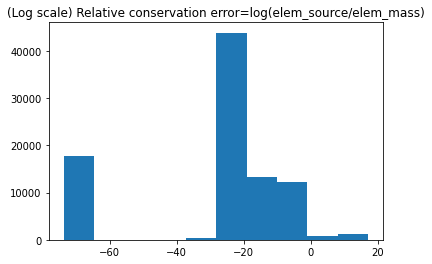

In [102]:
import matplotlib.pyplot as plt

# Sanity check: this should all be 0's (converted dYi/dt to dei/dt)
rel_error = np.log(element_sources.abs()/element_masses.abs() + 1e-32)
plt.hist(np.array(rel_error).flatten())
plt.title('(Log scale) Relative conservation error=log(elem_source/elem_mass)')
plt.show()

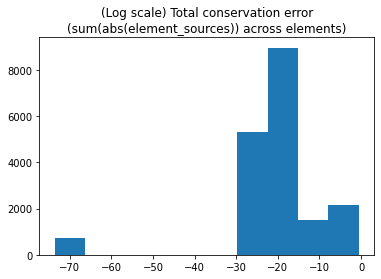

num data above 25: 0
median(element sources):  Ar    0.000000e+00
C     3.401839e-10
H     7.170726e-11
N     1.799306e-22
O     3.188694e-10
dtype: float64
mean(element sources):  Ar    0.000000e+00
C     6.133153e-04
H     9.464697e-05
N     6.262117e-07
O     9.647161e-04
dtype: float64
max(sum(element sources)) (sum across elements, max across data points):  0.6035585829453448
mean(sum(element sources)) (sum across elements, mean across data points):  0.001673304570399192


In [93]:
import matplotlib.pyplot as plt
plt.hist(np.log(element_sources.abs().sum(axis=1)+1e-32))
plt.title('(Log scale) Total conservation error\n(sum(abs(element_sources)) across elements)')
plt.show()

print('num data above 25:', (element_sources.abs().sum(axis=1)>25).sum())
print('median(element sources): ', element_sources.abs().median())
print('mean(element sources): ', element_sources.abs().mean())
print('max(sum(element sources)) (sum across elements, max across data points): ', element_sources.abs().sum(axis=1).max())
print('mean(sum(element sources)) (sum across elements, mean across data points): ', element_sources.abs().sum(axis=1).mean())

## Inspect Worst Case 

In [72]:
max_error_id = element_sources.abs().sum(axis=1).argmax()

Elements (legible):  ['H2' 'H' 'CH2' 'CH2(S)' 'CH3' 'CH4' 'CO' 'CO2' 'HCO' 'CH2O' 'CH2OH'
 'CH3O' 'O' 'CH3OH' 'C2H' 'C2H2' 'C2H3' 'C2H4' 'C2H5' 'C2H6' 'HCCO'
 'CH2CO' 'HCCOH' 'O2' 'N' 'NH' 'NH2' 'NH3' 'NNH' 'NO' 'NO2' 'N2O' 'HNO'
 'CN' 'OH' 'HCN' 'H2CN' 'HCNN' 'HCNO' 'HOCN' 'HNCO' 'NCO' 'AR' 'C3H7'
 'C3H8' 'H2O' 'CH2CHO' 'CH3CHO' 'N2' 'HO2' 'H2O2' 'C' 'CH']


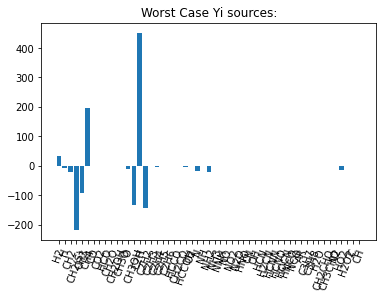

In [74]:
plt.bar(source_cols_stripped, source_data.iloc[max_error_id])
plt.xticks(rotation = 70)
plt.title('Worst Case Yi sources:')
print('Elements (legible): ', source_cols_stripped)

Text(0.5, 1.0, 'Worst Case Element sources:')

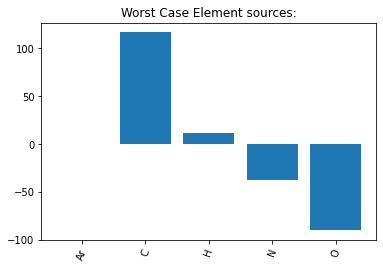

In [75]:
plt.bar(element_sources.columns, element_sources.iloc[max_error_id])
plt.xticks(rotation = 70)
plt.title('Worst Case Element sources:')